In [1]:
#%pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2
from tcrdist.repertoire import TCRrep
import pwseqdist as pw
from tcrdist.rep_funcs import _pws, _pw
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Loading in data and selecting relevant columns

In [2]:
df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')
# Based on the guidance, let's start preprocessing by filtering the dataset based on quality scores.

relevant_columns = [ 'cdr3.beta', 'v.beta', 'd.beta', 'j.beta',
    'species', 'mhc.b', 'antigen.gene','antigen.epitope', 'vdjdb.score'
]

# For the purpose of this example, we won't filter out lower-quality scores to avoid data imbalance,
# but in practice, you may want to consider this based on the dataset's size and distribution.
filtered_data = df[relevant_columns]
# Displaying the first few rows of the filtered dataset to verify the selection
filtered_data


C:\Users\vikra\AppData\Local\Temp\ipykernel_5908\1123533883.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')


,cdr3.beta,v.beta,d.beta,j.beta,species,mhc.b,antigen.gene,antigen.epitope,vdjdb.score
0,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
1,CASSFEAGQGFFSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
2,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
3,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
4,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
...,...,...,...,...,...,...,...,...,...
62172,CASSVRSTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,HomoSapiens,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,0
62173,CASSLRYTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,HomoSapiens,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,0
62174,CASSPGQGGDNEQFF,TRBV7-3*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-DQB1*02:01,Gluten,PQQPFPQPEQPFP,0
62175,CASSLGAGGQETQYF,TRBV5-1*01,NaN,TRBJ2-5*01,HomoSapiens,HLA-DQB1*02:01,Gluten,PQQPFPQPEQPFP,2


# examining missing and unique values

In [3]:
# Checking for missing values in crucial columns
missing_values = filtered_data.isnull().sum()

# Examining the number of unique values in categorical columns for potential encoding strategies
unique_values = filtered_data.nunique()

# Preparing the report
report = {
    "Missing Values": missing_values,
    "Unique Values": unique_values
}

report


{'Missing Values': cdr3.beta           7455
 v.beta              7446
 d.beta             41741
 j.beta              7541
 species                0
 mhc.b                  0
 antigen.gene          31
 antigen.epitope        0
 vdjdb.score            0
 dtype: int64,
 'Unique Values': cdr3.beta          41899
 v.beta                91
 d.beta                12
 j.beta                25
 species                3
 mhc.b                 45
 antigen.gene         268
 antigen.epitope     1169
 vdjdb.score            4
 dtype: int64}

In [5]:
# Removing rows with missing cdr3 sequences
df_cleaned = filtered_data.dropna(subset=['cdr3.beta'])
#df_cleaned = filtered_data.copy()
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned
missing_values_d = df_cleaned['d.beta'].isnull().sum()
missing_values_d

34322

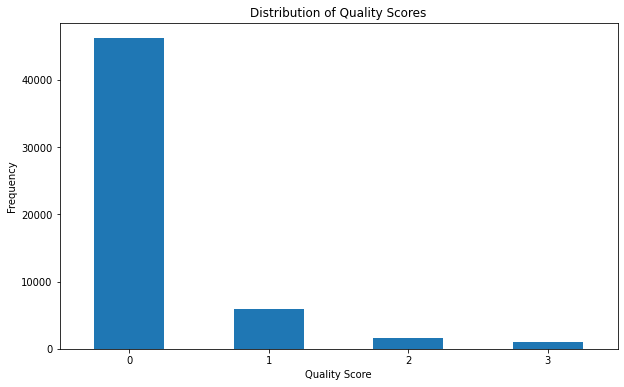

0    46198
1     5924
2     1600
3     1000
Name: vdjdb.score, dtype: int64

In [6]:
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is your cleaned DataFrame after removing rows with missing cdr3 sequences
quality_scores = df_cleaned['vdjdb.score'].value_counts()

# Plotting the distribution of quality scores
plt.figure(figsize=(10, 6))
quality_scores.plot(kind='bar')
plt.title('Distribution of Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keeping the x-axis labels horizontal for readability
plt.show()
quality_scores

whilst 0 is the most frequent class, the data with a score of 0 can be seen to be unreliable, so it is filtered out.

In [7]:
# Filtering out data points with a quality score of 0
df_filtered = df_cleaned[df_cleaned['vdjdb.score'] > 0]
# Removing the 'd.beta' column from the filtered DataFrame
df_filtered = df_filtered.drop(columns=['d.beta'])

df_filtered[:]



,cdr3.beta,v.beta,j.beta,species,mhc.b,antigen.gene,antigen.epitope,vdjdb.score
0,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
1,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
2,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
3,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
4,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
...,...,...,...,...,...,...,...,...
54677,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,HomoSapiens,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,2
54678,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,HomoSapiens,HLA-DQB1*02:01,Gluten,FPQPEQPFPWQP,2
54679,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,HomoSapiens,HLA-DQB1*02:01,Gluten,FPQPEQPFPWQP,2
54681,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,HomoSapiens,HLA-DQB1*02:01,Gluten,QLQPFPQPELPY,2


In [10]:
df_slim = df_filtered.copy()
df_slim.rename(columns={'cdr3.beta': 'cdr3_b_aa', 'v.beta': 'v_b_gene','j.beta': 'j_b_gene',}, inplace=True)

df_slim.to_csv('df_slim.csv', index = False)
df_slim

,cdr3_b_aa,v_b_gene,j_b_gene,species,mhc.b,antigen.gene,antigen.epitope,vdjdb.score
0,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
1,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
2,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
3,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
4,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,B2M,Nef,FLKEKGGL,2
...,...,...,...,...,...,...,...,...
54677,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,HomoSapiens,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,2
54678,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,HomoSapiens,HLA-DQB1*02:01,Gluten,FPQPEQPFPWQP,2
54679,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,HomoSapiens,HLA-DQB1*02:01,Gluten,FPQPEQPFPWQP,2
54681,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,HomoSapiens,HLA-DQB1*02:01,Gluten,QLQPFPQPELPY,2


In [11]:
print(df_slim['species'].unique())

['HomoSapiens' 'MusMusculus' 'MacacaMulatta']


In [12]:
df_mouse = df_slim[df_slim['species'] == 'MusMusculus']
df_human = df_slim[df_slim['species']=='HomoSapiens']
print(df_mouse.shape)
print(df_human.shape)

(1194, 8)
(6671, 8)


In [15]:
# Filtering rows where species is "Mus" (assuming "Mus" represents mouse)
# It seems from the initial peek that the dataset might not contain "Mus" directly, so let's filter for anything that's not "HomoSapiens"
# to potentially capture the mouse data if labeled differently (e.g., Mus musculus or simply Mus)



# Creating the datasets
# 1. Mouse species data with alpha chains
#human_alpha = df_human[['cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'species','antigen.gene',	'antigen.epitope']]

# 2. Mouse species data with beta chains
human_beta = df_human[['cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'species', 'antigen.gene','antigen.epitope']]

# 3. Mouse species data with both chains
#human_both = df_human.copy()
# Resetting index for each dataset before saving
#human_alpha.reset_index(drop=True, inplace=True)
#human_beta.reset_index(drop=True, inplace=True)
#human_both.reset_index(drop=True, inplace=True)


# Let's check the number of rows in each dataset to ensure we have mouse data
#mouse_alpha.shape[0], mouse_beta.shape[0], mouse_both.shape[0]

# Assuming your DataFrame is named mouse_beta_df and the epitope information is in a column named 'antigen.epitope'

# Count the occurrences of each epitope
#epitope_counts = human_beta['antigen.epitope'].value_counts()

# Filter for epitopes with more than 4 entries
#epitopes_with_more_than_four_entries = epitope_counts[epitope_counts > 4].index

# Filter the original DataFrame
#filtered_human_beta_df = mouse_beta[mouse_beta['antigen.epitope'].isin(epitopes_with_more_than_four_entries)]
human_beta['antigen.epitope'].value_counts()


NLVPMVATV     798
GILGFVFTL     425
GLCTLVAML     356
RAKFKQLL      239
KRWIILGLNK    230
             ... 
VLDLFQGQL       1
VMAPRTLVL       1
TMDFYQGQL       1
RMEQVDWTV       1
SMGVTYEM        1
Name: antigen.epitope, Length: 419, dtype: int64

In [16]:
human_beta.dropna(inplace=True)
human_beta.shape

C:\Users\vikra\AppData\Local\Temp\ipykernel_5908\822914630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_beta.dropna(inplace=True)


(6568, 6)

In [17]:
human_beta.drop_duplicates(inplace=True)

C:\Users\vikra\AppData\Local\Temp\ipykernel_5908\3693736366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_beta.drop_duplicates(inplace=True)


In [18]:
human_beta.shape

(4643, 6)

In [26]:
epitope_counts = human_beta['antigen.epitope'].value_counts()
filtered_epitopes = (epitope_counts[epitope_counts>110]).index.to_list()
print(len(filtered_epitopes))

10


In [27]:
human_beta = human_beta[human_beta['antigen.epitope'].isin(filtered_epitopes)]
human_beta.head()

,cdr3_b_aa,v_b_gene,j_b_gene,species,antigen.gene,antigen.epitope
664,CASSPQGLGTEAFF,TRBV28*01,TRBJ1-1*01,HomoSapiens,MLANA,ELAGIGILTV
729,CASSPGQLGNTIYF,TRBV4-3*01,TRBJ1-3*01,HomoSapiens,Gag,KRWIILGLNK
730,CASRLLGGGQETQYF,TRBV7-6*01,TRBJ2-5*01,HomoSapiens,Gag,KRWIILGLNK
731,CASSPGVFGVTQYF,TRBV4-3*01,TRBJ2-3*01,HomoSapiens,Gag,KRWIILGLNK
733,CASSQGVSSTEAFF,TRBV4-3*01,TRBJ1-1*01,HomoSapiens,Gag,KRWIILGLNK


In [28]:
human_beta.shape

(1783, 6)

In [42]:
# <chains> - tcrdist3 accepts ['alpha', 'beta'] or ['alpha'] or ['beta']
chains = ['beta']
# <cdr3> We can choose either 'cdr3' or 'all'. Choosing 'all' will
# compute distances using CDR1,CDR2, and CDR2.5 as well as CDR3
cdrs = 'all'
organism = 'human'
db_file = 'alphabeta_gammadelta_db.tsv'

In [43]:
tr = TCRrep(cell_df=human_beta,
            organism='human',
            chains=['beta'],
            db_file='alphabeta_gammadelta_db.tsv',
            deduplicate=True)

#tr.show_incomplete()

C:\Users\vikra\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\vikra\anaconda3\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [44]:
X_beta = pd.DataFrame(tr.pw_beta)
Y_beta = tr.clone_df['antigen.epitope'].copy() # target labels
X_beta.to_csv('X_beta.csv',index = False)
Y_beta.to_csv('Y_beta.csv',index = False)

#clustering

In [45]:
X_beta

,0,1,2,3,4,5,6,7,8,9,...,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782
0,0,170,154,170,167,154,155,147,156,131,...,158,155,128,158,176,158,170,115,154,152
1,170,0,105,21,103,144,117,147,147,182,...,115,139,157,145,157,145,97,127,175,154
2,154,105,0,96,105,96,96,139,139,157,...,97,109,157,178,145,109,133,116,211,122
3,170,21,96,0,100,138,96,144,144,170,...,121,139,154,148,157,145,97,124,172,154
4,167,103,105,100,0,90,118,84,78,177,...,151,151,172,175,103,151,139,130,203,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,158,145,109,145,151,157,130,159,159,155,...,48,36,108,117,108,0,84,134,218,120
1779,170,97,133,97,139,169,166,153,159,194,...,84,96,120,102,108,84,0,122,176,162
1780,115,127,116,124,130,164,151,146,146,167,...,122,131,122,170,149,134,122,0,191,136
1781,154,175,211,172,203,196,205,180,189,168,...,218,206,185,146,203,218,176,191,0,189


In [46]:
Y_beta = tr.clone_df['antigen.epitope'].copy()
Y_beta

0         ATDALMTGY
1       KAFSPEVIPMF
2         NLVPMVATV
3       KAFSPEVIPMF
4         YLQPRTFLL
           ...     
1778      NLVPMVATV
1779      NLVPMVATV
1780     KRWIILGLNK
1781    KAFSPEVIPMF
1782    KAFSPEVIPMF
Name: antigen.epitope, Length: 1783, dtype: object

In [47]:
df_m = X_beta.copy()
df_m['epitope'] = Y_beta

In [48]:
df_m.head()

,0,1,2,3,4,5,6,7,8,9,...,1774,1775,1776,1777,1778,1779,1780,1781,1782,epitope
0,0,170,154,170,167,154,155,147,156,131,...,155,128,158,176,158,170,115,154,152,ATDALMTGY
1,170,0,105,21,103,144,117,147,147,182,...,139,157,145,157,145,97,127,175,154,KAFSPEVIPMF
2,154,105,0,96,105,96,96,139,139,157,...,109,157,178,145,109,133,116,211,122,NLVPMVATV
3,170,21,96,0,100,138,96,144,144,170,...,139,154,148,157,145,97,124,172,154,KAFSPEVIPMF
4,167,103,105,100,0,90,118,84,78,177,...,151,172,175,103,151,139,130,203,138,YLQPRTFLL


In [49]:
df_bgm = df_m.copy()

In [50]:
print(len(df_m['epitope'].unique()))

10


In [51]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_beta)

tsne = TSNE(n_components = 2, random_state= 42)

tsne_result = tsne.fit_transform(X_scaled)

C:\Users\vikra\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\vikra\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [52]:
df_m['tsne_1'] = tsne_result[:,0]
df_m['tsne_2'] = tsne_result[:,1]
df_m = df_m.sort_values('epitope')

In [53]:
df_m.head()

,0,1,2,3,4,5,6,7,8,9,...,1776,1777,1778,1779,1780,1781,1782,epitope,tsne_1,tsne_2
0,0,170,154,170,167,154,155,147,156,131,...,158,176,158,170,115,154,152,ATDALMTGY,-8.059057,51.739540
1187,165,171,145,171,102,106,150,118,121,177,...,161,113,161,176,167,181,138,ATDALMTGY,36.515320,9.291432
1185,162,171,145,171,102,106,150,118,121,177,...,161,113,161,176,167,181,138,ATDALMTGY,36.524277,9.292052
106,72,168,139,156,162,175,144,111,120,115,...,159,183,150,162,122,159,152,ATDALMTGY,-3.862946,54.505222
107,159,180,160,159,174,160,120,123,117,139,...,192,186,171,186,182,180,155,ATDALMTGY,-15.580961,5.175153


<Figure size 20000x20000 with 0 Axes>

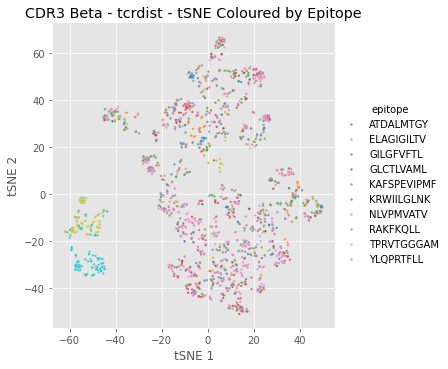

In [59]:
import seaborn as sns
#sns.set(rc = {'figure.figsize':(10,10)})
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(20, 20), dpi = 1000)

#sns.set_style = "whitegrid"



figure = sns.relplot(data=df_m,x=tsne_result[:, 0],y= tsne_result[:, 1], s= 6, alpha= 0.7, hue='epitope', palette = 'tab10', legend = "full")

plt.title('CDR3 Beta - tcrdist - tSNE Coloured by Epitope')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.savefig('tcrdist_betaslim2.png', dpi =1000, bbox_inches = 'tight')